In [ ]:
import nltk
import pandas as pd
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer

In [194]:
!pip install transformers
from transformers import pipeline
senti = pipeline("sentiment-analysis", model="siebert/sentiment-roberta-large-english")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [195]:
import tweepy

In [196]:
api_key = "Zf5TkFjjbqxyzC02cFNbrfd2V"
api_key_secret = "afUdvsB5rueFfZhAFguKlpbhzyFwL1rEp898MSj1HBBh7In8Sk"

access_token = '1420374454392156165-XUOMDIw2YmAIcF1xZVyp4Y50JEGUlB'
access_token_secret = 'rVOG17Kl7vZf8wB3cLt9X6YRk3LrEJctL48KyqX2SPqJI'

In [197]:
keyword = str(input("Enter Keyword : "))

Enter Keyword : nasdaq stocks


# SNSCRAPE

In [198]:
# !pip install snscrape

In [199]:
# import snscrape.modules.twitter as sntwitter

# data = f'({keyword}) until:2023-04-01 since:2010-01-01'
# tweets = []

# for tweet in sntwitter.TwitterSearchScraper(keyword).get_items():
#     if len(tweets) == 5000:
#         break
#     else:
#         tweets.append([tweet.date, tweet.user.username, tweet.content])

# df = pd.DataFrame(tweets, columns=['Date', 'User', 'Tweet'])
# df.to_csv('tweets_2.csv')

# Twitter API

In [200]:
auth = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

# public_tweets = api.search_tweets(q=keyword, tweet_mode='extended', count=500)
cursor = tweepy.Cursor(api.search_tweets, q=keyword, count=200,tweet_mode='extended').items(100)

columns = ['Time', 'User', 'Tweet']
data = []

# for tweet in public_tweets:
#     data.append([tweet.created_at, tweet.user.screen_name, tweet.full_text])
for tweet in cursor:
    data.append([tweet.created_at, tweet.user.screen_name, tweet.full_text])

df = pd.DataFrame(data, columns=columns)
df.to_csv('tweets.csv')

# NLP

In [201]:
english_stopwords = stopwords.words('english')

def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in english_stopwords]

stemmer = SnowballStemmer(language='english')

def tokenize(text):
    return [stemmer.stem(word) for word in word_tokenize(text)]

small_vect = CountVectorizer()
vectorizer = CountVectorizer(lowercase=True, 
                             tokenizer=tokenize,
                             stop_words=english_stopwords,
                             max_features=1000)

In [202]:
df = pd.read_csv('tweets.csv')

In [203]:
%%time
df['Result'] = df['Tweet'].apply(lambda x: senti(x))
df['sentiment'] = df['Result'].apply(lambda x: (x[0]['label']))

CPU times: user 1min 3s, sys: 134 ms, total: 1min 3s
Wall time: 1min 4s


In [204]:
df['sentiment'].value_counts(normalize=True)

POSITIVE    0.63
NEGATIVE    0.37
Name: sentiment, dtype: float64

In [205]:
import plotly.express as px
fig = px.histogram(df, x='sentiment',color='sentiment',text_auto=True)
fig.show()

In [206]:
df.to_csv('tweets_sentiments.csv')

In [207]:
from sklearn.linear_model import LogisticRegression

In [208]:
MAX_ITER = 1000
model = LogisticRegression(max_iter=MAX_ITER, solver='sag')

In [209]:
train_df = pd.read_csv('tweets_sentiments.csv')

In [210]:
train_inputs = train_df['Tweet']
train_targets = train_df['sentiment']

In [211]:
# pd.DataFrame(train_inputs)
train_inputs

0     @sinaEstavi @NasdaqExchange @bridge_oracle Int...
1     RT @mathovermyth: #MathOverMyth Weekend Watchl...
2     RT @Maria04726725: The following are some exam...
3     RT @PrimeXBT: 📉 The #Nasdaq is experiencing a ...
4     $GLNG  new alert at https://t.co/A7qrDarJHY  #...
                            ...                        
95    RT @FluentInFinance: 18% of the S&amp;P 500 an...
96    $LW  new alert at https://t.co/A7qrDarJHY  #st...
97    $LW  new alert at https://t.co/A7qrDarJHY  #st...
98    $WAL  new alert at https://t.co/A7qrDarJHY  #s...
99    China's Nasdaq-style Star 50 Index has rallied...
Name: Tweet, Length: 100, dtype: object

In [212]:
%%time
vectorizer.fit(train_inputs)
# vectorizer.get_feature_names_out()
train_inputs = vectorizer.transform(train_inputs)

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.



CPU times: user 183 ms, sys: 0 ns, total: 183 ms
Wall time: 218 ms


In [213]:
%%time
model.fit(train_inputs, train_targets)

CPU times: user 22.5 ms, sys: 0 ns, total: 22.5 ms
Wall time: 24.8 ms


LogisticRegression(max_iter=1000, solver='sag')

In [214]:
train_preds = model.predict(train_inputs)
train_targets

0     POSITIVE
1     POSITIVE
2     NEGATIVE
3     POSITIVE
4     POSITIVE
        ...   
95    NEGATIVE
96    POSITIVE
97    POSITIVE
98    POSITIVE
99    POSITIVE
Name: sentiment, Length: 100, dtype: object

In [215]:
pd.Series(train_preds).value_counts()

POSITIVE    64
NEGATIVE    36
dtype: int64

In [216]:
pd.Series(train_targets).value_counts()

POSITIVE    63
NEGATIVE    37
Name: sentiment, dtype: int64

In [217]:
from sklearn.metrics import accuracy_score

In [218]:
accuracy_score(train_targets, train_preds)

0.99

In [219]:
prv = pd.Series(train_targets).value_counts()[0]

## Working on 100 rows Dataset

In [220]:
dp = []
dp2 = []

In [221]:
df2 = pd.read_csv('tweets_2.csv')

In [222]:
inputs = df2.iloc[:100, 3:4]

### SA on new tweets

In [223]:
%%time
inputs['Result'] = inputs['Tweet'].apply(lambda x: senti(x))
inputs['sentiment'] = inputs['Result'].apply(lambda x: (x[0]['label']))

CPU times: user 1min 15s, sys: 174 ms, total: 1min 16s
Wall time: 1min 26s


In [224]:
new_inputs = inputs['Tweet']
new_targets = inputs['sentiment']

In [225]:
new_inputs.shape

(100,)

In [226]:
%%time
vectorizer.fit(new_inputs)
new_inputs = vectorizer.transform(new_inputs)

CPU times: user 110 ms, sys: 9 µs, total: 110 ms
Wall time: 111 ms


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [227]:
model.fit(new_inputs, new_targets)

LogisticRegression(max_iter=1000, solver='sag')

In [228]:
new_preds = model.predict(new_inputs)

In [229]:
pd.Series(new_preds).value_counts()

POSITIVE    69
NEGATIVE    31
dtype: int64

In [230]:
pd.Series(new_targets).value_counts()

POSITIVE    69
NEGATIVE    31
Name: sentiment, dtype: int64

In [231]:
preds_1 = pd.Series(new_preds).value_counts()[0]
targets_1 = pd.Series(new_targets).value_counts()[0]
dp.append(preds_1)
dp2.append(targets_1)

In [232]:
percentage = ((preds_1-prv)/preds_1)*100

In [233]:
if percentage > 0:
  print("increase of",percentage)
else:
  print("decrease of",abs(percentage))

increase of 8.695652173913043


In [234]:
import matplotlib.pyplot as plt
def graph(x,y):
  # plotting the points 
  plt.plot(x, y)
    
  # naming the x axis
  plt.xlabel('x - axis')
  # naming the y axis
  plt.ylabel('y - axis')
    
  # giving a title to my graph
  plt.title('Stock')
    
  # function to show the plot
  plt.show()

## 2nd DF

In [235]:
inputs = df2.iloc[101:200, 3:4]

In [236]:
%%time
inputs['Result'] = inputs['Tweet'].apply(lambda x: senti(x))
inputs['sentiment'] = inputs['Result'].apply(lambda x: (x[0]['label']))

CPU times: user 1min 14s, sys: 132 ms, total: 1min 14s
Wall time: 1min 16s


In [237]:
new_inputs = inputs['Tweet']
new_targets = inputs['sentiment']

In [238]:
new_inputs.shape

(99,)

In [239]:
%%time
vectorizer.fit(new_inputs)
new_inputs = vectorizer.transform(new_inputs)

CPU times: user 110 ms, sys: 1.99 ms, total: 112 ms
Wall time: 115 ms


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [240]:
new_preds = model.predict(new_inputs)

In [241]:
pd.Series(new_preds).value_counts()

NEGATIVE    55
POSITIVE    44
dtype: int64

In [242]:
pd.Series(new_targets).value_counts()

POSITIVE    62
NEGATIVE    37
Name: sentiment, dtype: int64

In [243]:
preds_2 = pd.Series(train_preds).value_counts()[0]
targets_2 = pd.Series(new_targets).value_counts()[0]
dp.append(preds_2)
dp2.append(targets_2)

In [244]:
percentage = ((preds_2-preds_1)/preds_2)*100

In [245]:
if percentage > 0:
  print("increase of",percentage)
else:
  print("decrease of",abs(percentage))

decrease of 7.8125


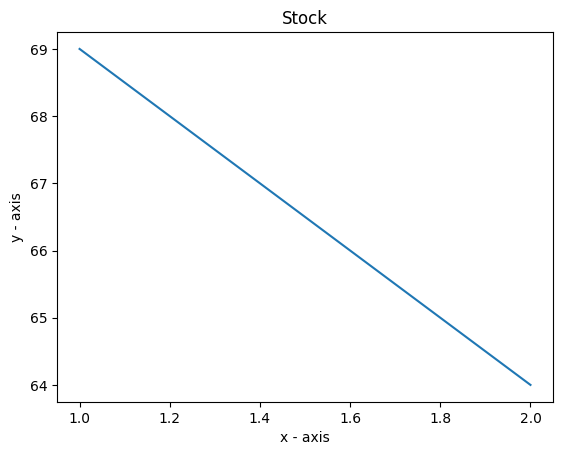

In [246]:
graph([1,2],dp)

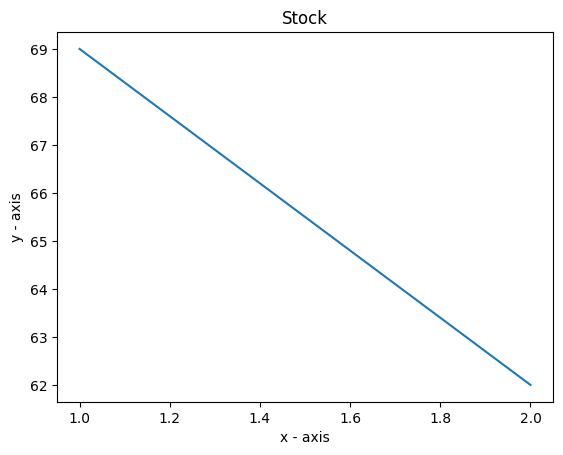

In [247]:
graph([1,2],dp2)

## 3rd DF

In [248]:
inputs = df2.iloc[201:300, 3:4]

inputs['Result'] = inputs['Tweet'].apply(lambda x: senti(x))
inputs['sentiment'] = inputs['Result'].apply(lambda x: (x[0]['label']))

new_inputs = inputs['Tweet']
new_targets = inputs['sentiment']

vectorizer.fit(new_inputs)
new_inputs = vectorizer.transform(new_inputs)

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [249]:
new_inputs.shape

(99, 729)

In [250]:
model.fit(new_inputs, new_targets)

LogisticRegression(max_iter=1000, solver='sag')

In [251]:
new_preds = model.predict(new_inputs)

In [252]:
pd.Series(new_preds).value_counts()

POSITIVE    78
NEGATIVE    21
dtype: int64

In [253]:
pd.Series(new_targets).value_counts()

POSITIVE    78
NEGATIVE    21
Name: sentiment, dtype: int64

In [254]:
preds_3 = pd.Series(new_preds).value_counts()[0]
targets_3 = pd.Series(new_targets).value_counts()[0]
if len(dp) == 3:
  dp.remove(dp[2])
if len(dp2) == 3:
  dp2.remove(dp[2])
dp.append(preds_3)
dp2.append(targets_3)

percentage = ((preds_3-preds_2)/preds_3)*100

if percentage > 0:
  print("increase of",percentage)
else:
  print("decrease of",abs(percentage))

increase of 17.94871794871795


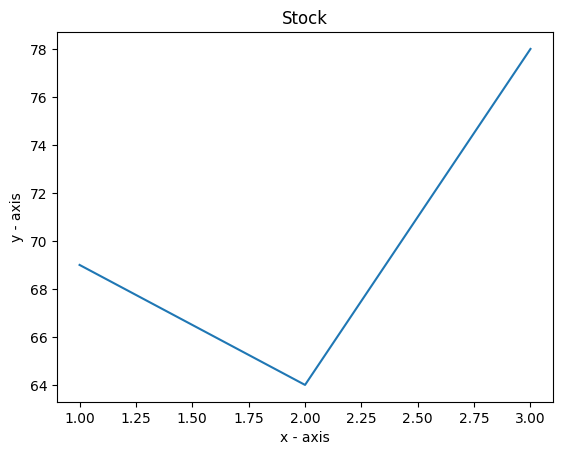

In [255]:
graph([1,2,3], dp)

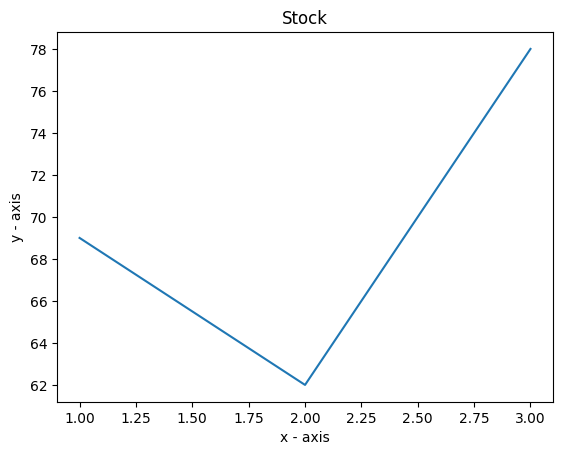

In [256]:
graph([1,2,3], dp2)

## 4th DF

In [257]:
inputs = df2.iloc[301:400, 3:4]

inputs['Result'] = inputs['Tweet'].apply(lambda x: senti(x))
inputs['sentiment'] = inputs['Result'].apply(lambda x: (x[0]['label']))

new_inputs = inputs['Tweet']
new_targets = inputs['sentiment']

vectorizer.fit(new_inputs)
new_inputs = vectorizer.transform(new_inputs)

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [258]:
new_inputs.shape

(99, 547)

In [259]:
model.fit(new_inputs, new_targets)

LogisticRegression(max_iter=1000, solver='sag')

In [260]:
new_preds = model.predict(new_inputs)

In [261]:
preds_4 = pd.Series(new_preds).value_counts()[0]
targets_4 = pd.Series(new_targets).value_counts()[0]

if len(dp) == 4:
  dp.remove(dp[3])
if len(dp2) == 4:
  dp2.remove(dp[3])
dp.append(preds_4)
dp2.append(targets_4)

percentage = ((preds_4-preds_3)/preds_4)*100

if percentage > 0:
  print("increase of",percentage)
else:
  print("decrease of",abs(percentage))

decrease of 30.0


In [ ]:
graph([1,2,3,4], dp)

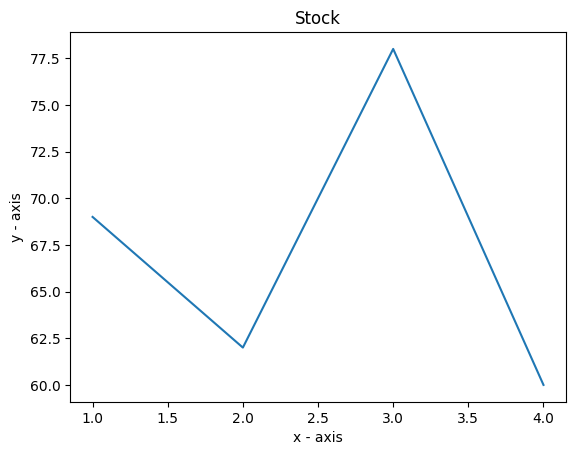

In [262]:
graph([1,2,3,4], dp2)

## 5th DF

In [263]:
inputs = df2.iloc[401:500, 3:4]

inputs['Result'] = inputs['Tweet'].apply(lambda x: senti(x))
inputs['sentiment'] = inputs['Result'].apply(lambda x: (x[0]['label']))

new_inputs = inputs['Tweet']
new_targets = inputs['sentiment']

vectorizer.fit(new_inputs)
new_inputs = vectorizer.transform(new_inputs)

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [264]:
new_inputs.shape

(99, 551)

In [265]:
model.fit(new_inputs, new_targets)

LogisticRegression(max_iter=1000, solver='sag')

In [266]:
new_preds = model.predict(new_inputs)

In [267]:
preds_5 = pd.Series(new_preds).value_counts()[0]
targets_5 = pd.Series(new_targets).value_counts()[0]

if len(dp) == 5:
  dp.remove(dp[4])
if len(dp2) == 5:
  dp2.remove(dp[4])
dp.append(preds_5)
dp2.append(targets_5)

percentage = ((preds_5-preds_4)/preds_5)*100

if percentage > 0:
  print("increase of",percentage)
else:
  print("decrease of",abs(percentage))

increase of 26.82926829268293


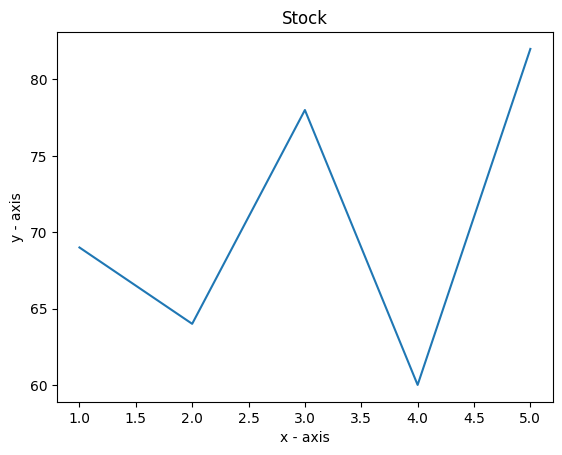

In [268]:
graph([1,2,3,4,5], dp)

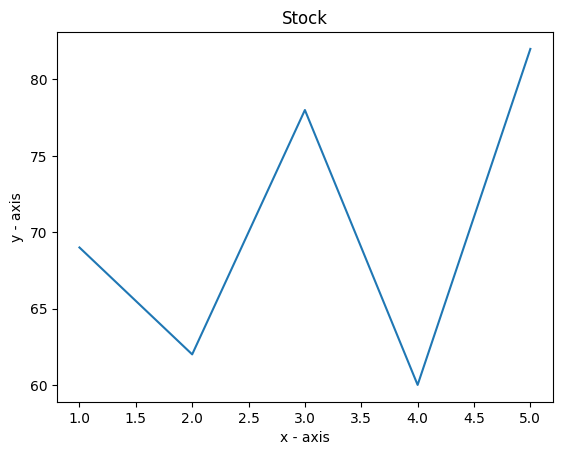

In [269]:
graph([1,2,3,4,5], dp2)